In [1]:
!pip install yfinance --quiet
!pip install getFamaFrenchFactors --quiet
!pip install pymysql --quiet
!pip install selenium --quiet
!pip install webdriver-manager --quiet

In [2]:
#필요 라이브러리
import talib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error,  mean_absolute_error, mean_absolute_percentage_error
from sklearn import metrics
from sklearn.model_selection import train_test_split
from scipy import stats
import statsmodels.api as sm
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import warnings
import yfinance as yf
import getFamaFrenchFactors as gff
from statsmodels.regression.rolling import RollingOLS
import FinanceDataReader as fdr
sns.set()
import requests as rq
from bs4 import BeautifulSoup
import re
import pymysql
from sqlalchemy import create_engine
from datetime import date
from dateutil.relativedelta import relativedelta
import time
from tqdm import tqdm
from io import BytesIO
import keyring
import zipfile
import json
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from webdriver_manager.chrome import ChromeDriverManager
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 듀얼모멘텀 확인

In [3]:
data1=yf.Ticker('^GSPC')
abm=data1.history(period='1y',actions=False)
data2=yf.Ticker('ACWX')
rem=data2.history(period='1y',actions=False)
abm.drop(['Open','High','Low','Volume'],axis=1,inplace=True)
rem.drop(['Open','High','Low','Volume'],axis=1,inplace=True)

In [4]:
abmret=abm.pct_change().dropna()
remret=rem.pct_change().dropna()

abmy=abmret.rolling(250).mean().dropna()*252
remy=remret.rolling(250).mean().dropna()*252

In [5]:
(abmy-remy)

,Close
Date,
2023-06-09 00:00:00-04:00,0.028126


듀얼모멘텀 전략입니다. S&P가 ACWX 보다 1년 수익률이 높은 상태이므로 현재는 S&P500으로 모멘텀 전략을 실행합니다.

최근들어 효율적 위험관리를 위해 무조건 가치투자만 하는것이 아닌 다양한 팩터로 분산하여 투자하고 있습니다. 저는 현재는 밸류 +듀얼모멘텀 +캐리 로 분산하고 있습니다.

In [143]:
#미국채종합지수

# 국내주식

In [4]:
data=fdr.DataReader('035420','2013') #네이버
data=data['Close']

<Axes: xlabel='Date'>

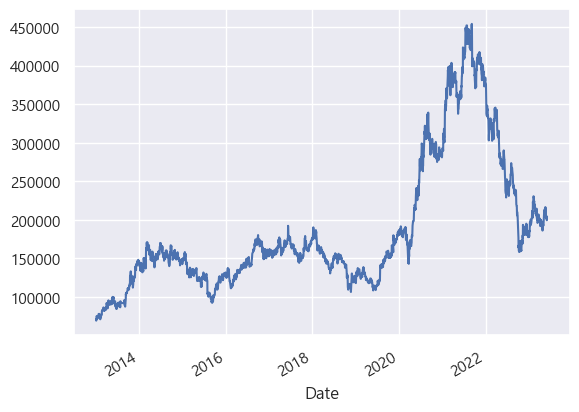

In [5]:
data.plot()

In [6]:
datadev=talib.STDDEV(data,timeperiod=60, nbdev=2)
datadev= datadev.fillna(method='bfill')
losscut= data-datadev
losscut.tail()

Date
2023-05-26    187230.881201
2023-05-30    186285.780043
2023-05-31    184328.607330
2023-06-01    189226.668547
2023-06-02    189446.581539
dtype: float64

1차 손절선입니다. 2 std(95%)를 기준으로 잡았고 본인 기호에 맞게 1,2,3 조정해서 사용하면 됩니다.

In [7]:
revenue= data+datadev
revenue.tail()

Date
2023-05-26    217769.118799
2023-05-30    216714.219957
2023-05-31    214671.392670
2023-06-01    218773.331453
2023-06-02    218553.418461
dtype: float64

마찬가지로 1차 익절선입니다. 이 부분이 뚫리면 30%정도 익절(손절)합니다. 확실한 전고(저)점이 있다면 이를 사용하기도 합니다. 마찬가지로 본인 기호에 맞게 사용하시면 됩니다. 

저는 위 방식은 모멘텀 또는 top-down 방식으로 정한 주식에 한정에 사용합니다. bottom-up으로 종목을 선정한 경우 주가가 낮아지면 오히려 매수기회로 보기도 합니다.

In [7]:
api_key ='1234'
corp_code='00266961' #NAVER
bsns_year='2022' 
bgn_de='2016-01-01'
end_de='2023-05-01'
reprt_code='11011' #사업보고서

url_div=f'''https://opendart.fss.or.kr/api/alotMatter.json?crtfc_key={api_key}
&corp_code={corp_code}&bsns_year={bsns_year}&reprt_code={reprt_code}'''

div_data_ss= rq.get(url_div)
div_data_ss_df= div_data_ss.json().get('list')
div_data_ss_df= pd.DataFrame(div_data_ss_df)

div_data_ss_df

,rcept_no,corp_cls,corp_code,corp_name,se,thstrm,frmtrm,lwfr,stock_knd
0,20230314001049,Y,00266961,NAVER,주당액면가액(원),100,100,100,NaN
1,20230314001049,Y,00266961,NAVER,(연결)당기순이익(백만원),"760,261","16,489,850","1,002,087",NaN
2,20230314001049,Y,00266961,NAVER,(별도)당기순이익(백만원),"1,092,158","1,524,755","1,196,925",NaN
3,20230314001049,Y,00266961,NAVER,(연결)주당순이익(원),"5,007","9,977","7,857",NaN
4,20230314001049,Y,00266961,NAVER,현금배당금총액(백만원),"137,072","76,292","59,279",NaN
5,20230314001049,Y,00266961,NAVER,주식배당금총액(백만원),-,-,-,NaN
6,20230314001049,Y,00266961,NAVER,(연결)현금배당성향(%),18.00,0.50,5.90,NaN
7,20230314001049,Y,00266961,NAVER,현금배당수익률(%),0.40,0.10,0.10,보통주
8,20230314001049,Y,00266961,NAVER,현금배당수익률(%),-,-,-,종류주
9,20230314001049,Y,00266961,NAVER,주식배당수익률(%),-,-,-,보통주


네이버의 open dart 사업보고서 배당 정보입니다. 다른 사이트에서 크롤링으로 주요정보들을 가져올 수 있지만 저작권문제의 소지가 있으므로 가능하면 open dart를 사용하려고 합니다. .json 앞부분만 바꿔주면 회사채 발행, 미상환, 소송 내역 등등 유용한 정보를 얻을 수 있습니다.

In [9]:
#무료사이트
url='https://comp.fnguide.com/SVO2/ASP/SVD_Finance.asp?pGB=1&gicode=A035420&cID=&MenuYn=Y&ReportGB=&NewMenuID=103&stkGb=701'
table= pd.read_html(url)
data=table[0]
data=data.T
data.T

,IFRS(연결),2020/12,2021/12,2022/12,2023/03,전년동기,전년동기(%)
0,매출액,53041.0,68176.0,82201.0,22804.0,18452.0,23.6
1,매출원가,NaN,NaN,NaN,NaN,NaN,NaN
2,매출총이익,53041.0,68176.0,82201.0,22804.0,18452.0,23.6
3,판매비와관리비계산에 참여한 계정 펼치기,40888.0,54921.0,69154.0,19500.0,15434.0,26.3
4,영업이익,12153.0,13255.0,13047.0,3305.0,3018.0,9.5
5,영업이익(발표기준),12153.0,13255.0,13047.0,3305.0,3018.0,9.5
6,금융수익계산에 참여한 계정 펼치기,5246.0,7857.0,6789.0,1440.0,1618.0,-11.0
7,금융원가계산에 참여한 계정 펼치기,1464.0,3493.0,9315.0,1849.0,2097.0,-11.9
8,기타수익계산에 참여한 계정 펼치기,434.0,527.0,3106.0,158.0,2350.0,-93.3
9,기타비용계산에 참여한 계정 펼치기,1188.0,2329.0,3757.0,1494.0,847.0,76.3


Text(0.5, 1.0, 'EBIT')

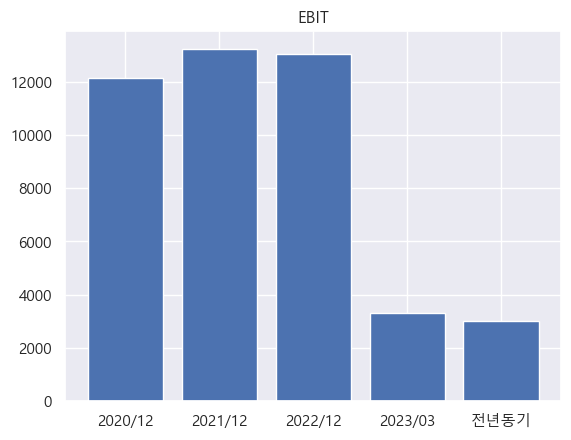

In [10]:
data_ebit=pd.DataFrame(data[4])
data_ebit=data_ebit.iloc[1:6]
plt.bar(x=data_ebit.index,height=data_ebit[4])
plt.title('EBIT')

# 해외주식 활용

In [6]:
api='1234'
url=f'https://financialmodelingprep.com/api/v3/income-statement/AAPL?limit=200&apikey={api}'.format(api)
df=pd.read_json(url)
df

,date,symbol,reportedCurrency,cik,fillingDate,acceptedDate,calendarYear,period,revenue,costOfRevenue,...,incomeBeforeTaxRatio,incomeTaxExpense,netIncome,netIncomeRatio,eps,epsdiluted,weightedAverageShsOut,weightedAverageShsOutDil,link,finalLink
0,2022-09-24,AAPL,USD,320193,2022-10-28,2022-10-27 18:01:14,2022,FY,394328000000,223546000000,...,0.302040,19300000000,99803000000,0.253096,6.15,6.11,16215963000,16325819000,https://www.sec.gov/Archives/edgar/data/320193...,https://www.sec.gov/Archives/edgar/data/320193...
1,2021-09-25,AAPL,USD,320193,2021-10-29,2021-10-28 18:04:28,2021,FY,365817000000,212981000000,...,0.298529,14527000000,94680000000,0.258818,5.67,5.61,16701272000,16864919000,https://www.sec.gov/Archives/edgar/data/320193...,https://www.sec.gov/Archives/edgar/data/320193...
2,2020-09-26,AAPL,USD,320193,2020-10-30,2020-10-29 18:06:25,2020,FY,274515000000,169559000000,...,0.244398,9680000000,57411000000,0.209136,3.31,3.28,17352119000,17528214000,https://www.sec.gov/Archives/edgar/data/320193...,https://www.sec.gov/Archives/edgar/data/320193...
3,2019-09-28,AAPL,USD,320193,2019-10-31,2019-10-30 18:12:36,2019,FY,260174000000,161782000000,...,0.252666,10481000000,55256000000,0.212381,2.99,2.97,18471336000,18595652000,https://www.sec.gov/Archives/edgar/data/320193...,https://www.sec.gov/Archives/edgar/data/320193...
4,2018-09-29,AAPL,USD,320193,2018-11-05,2018-11-05 08:01:40,2018,FY,265595000000,163756000000,...,0.274489,13372000000,59531000000,0.224142,3.00,2.98,19821508000,20000436000,https://www.sec.gov/Archives/edgar/data/320193...,https://www.sec.gov/Archives/edgar/data/320193...


FMP 사이트를 이용해 재무제표를 불러옵니다. 저는 무료버전이라 5년 밖에 안됩니다.
또한 &period=quater를 추가하면 분기별로 볼 수 있습니다. 또한 income-statement 부분을 balance-sheet-statement로 바꾸거나 cash-flow-statement 로 바꾸면 위 재무제표를 볼 수 있습니다  

재무제표 외에도 유용한 정보가 많이 있습니다(https://financialmodelingprep.com/api/v3/ratios-ttm/AAPL?apikey=YOUR_API_KEY) 등. 그러나 대부분 월 19$ 결제를 해야 사용할 수 있습니다 ㅠ

In [29]:
!pip install feedparser --quiet
!pip install newspaper3k --quiet
!pip install konlpy --quiet
!pip install MeCab --quiet
!pip install wordcloud --quiet

In [30]:
%matplotlib inline
import feedparser
import newspaper
from konlpy.tag import Mecab
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from konlpy.tag import Twitter
from collections import Counter
import MeCab